In [ ]:
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import os
import glob
from torch.utils.data import DataLoader
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision import models
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torchvision.utils as vutils
from torch.utils.data import ConcatDataset
import torch
from google.colab import drive


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# pip install --upgrade torch torchvision

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/dl-2025-competition-1.zip

In [ ]:
print("Файл найден?", os.path.exists("/content/drive/MyDrive/dl-2025-competition-1.zip"))

Файл найден? True


In [ ]:
# !ls "/content/drive/MyDrive"

In [ ]:
!ls data

test  train


In [ ]:
!ls sample_submission.csv

sample_submission.csv


## **Кущенко Валерия - id 25**

для удобного перемещения по ноутбуку передвигайтесь по заголовкам в меню - p.s. gan выполнен в самом конце

## начало работы

из важного: сортируем файлы в тестовом датасете, добавляем условную аугментацию, читаем картинки

In [ ]:
class ImageFolderDataset(Dataset):
    def __init__(self, split="train", root_dir="data/train", transform=None, rare_class_transform=None):
        self.split = split
        self.transform = transform
        self.rare_class_transform = rare_class_transform
        self.samples = []

        if split == "test":
            root_dir = "data/test"
            image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(os.path.join(root_dir, "*.png"))
            # также отсортируем
            def extract_number(path):
                imya = os.path.splitext(os.path.basename(path))[0]
                return int(imya) if imya.isdigit() else float("inf")

            image_files = sorted(image_files, key=extract_number)

            for file_path in image_files:
                self.samples.append((file_path, 0))
        else:

            def split_files(files, split):
                n = len(files)
                if split == "train":
                    return files[: int(0.8 * n)]
                elif split == "val":
                    return files[int(0.8 * n) :]
                elif split == "train_itog":
                    return files

            for class_folder in sorted(os.listdir(root_dir)):
                class_path = os.path.join(root_dir, class_folder)
                if os.path.isdir(class_path):
                    class_idx = int(class_folder)
                    image_files = glob.glob(os.path.join(class_path, "*"))
                    split_files_list = split_files(image_files, split)
                    for file_path in split_files_list:
                        self.samples.append((file_path, class_idx))
        # найдем редкие классы (потом их отправим в условную аугментацию)
        label_counts = Counter([label for x, label in self.samples])
        self.rare_classes = {label for label, count in label_counts.items() if count < 40}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = np.array(img_pil.resize((64, 64), Image.BILINEAR) )

        if self.transform:
          # условная агументация
            if label in self.rare_classes and self.rare_class_transform:
                augmented = self.rare_class_transform(image=image)
            else:
                augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

## аугментации, даталоудеры, датасеты...

аугментации бесстыжим образом были подсмотрены в семинарском ноутбуке

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=0.1),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
train_transform_navorochenny = A.Compose(
    [
        A.Resize(224, 224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.RandomOrder(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.3),
                A.ElasticTransform(p=0.3),
            ]
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
rare_class_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
val_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)

In [ ]:
# построим семплер который берет более редкие классы в батчи чаще
labels = [label for x, label in train_dataset.samples]
sample_weights = (1.0 / torch.tensor(np.bincount(labels), dtype=torch.float))[labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Посмотрим на данные и проанализируем их

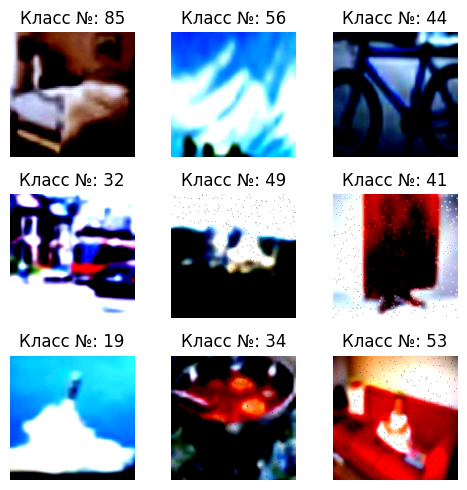

In [ ]:
def imshow(img_tensor, title, plt_ax):
    img = img_tensor.permute(1, 2, 0).numpy()
    plt_ax.imshow(img)
    plt_ax.set_title(title)
    plt_ax.axis("off")

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5), sharey=True, sharex=True)
for x in ax.flatten():
    im_train, label = train_dataset[int(np.random.uniform(0, len(train_dataset)))]
    imshow(im_train.cpu(), title=f"Класс №: {label}", plt_ax=x)
plt.tight_layout()
plt.show()

In [ ]:
labels = [label for x, label in train_dataset]
num_classes = len(set(labels))
print(f"Будем классифицировать много классов: {num_classes}")

Будем классифицировать много классов: 100


In [ ]:
labels = [label for x, label in train_dataset.samples]
amount_of_classes= Counter(labels)
for cls, count in sorted(amount_of_classes.items())[:10]:
    print(f"Класс {cls}: {count} изображений")
print(f"\nВсего классов: {len(amount_of_classes)}")

Класс 0: 88 изображений
Класс 1: 87 изображений
Класс 2: 114 изображений
Класс 3: 95 изображений
Класс 4: 108 изображений
Класс 5: 36 изображений
Класс 6: 98 изображений
Класс 7: 109 изображений
Класс 8: 36 изображений
Класс 9: 39 изображений

Всего классов: 100


Посмотрим на распределение классов

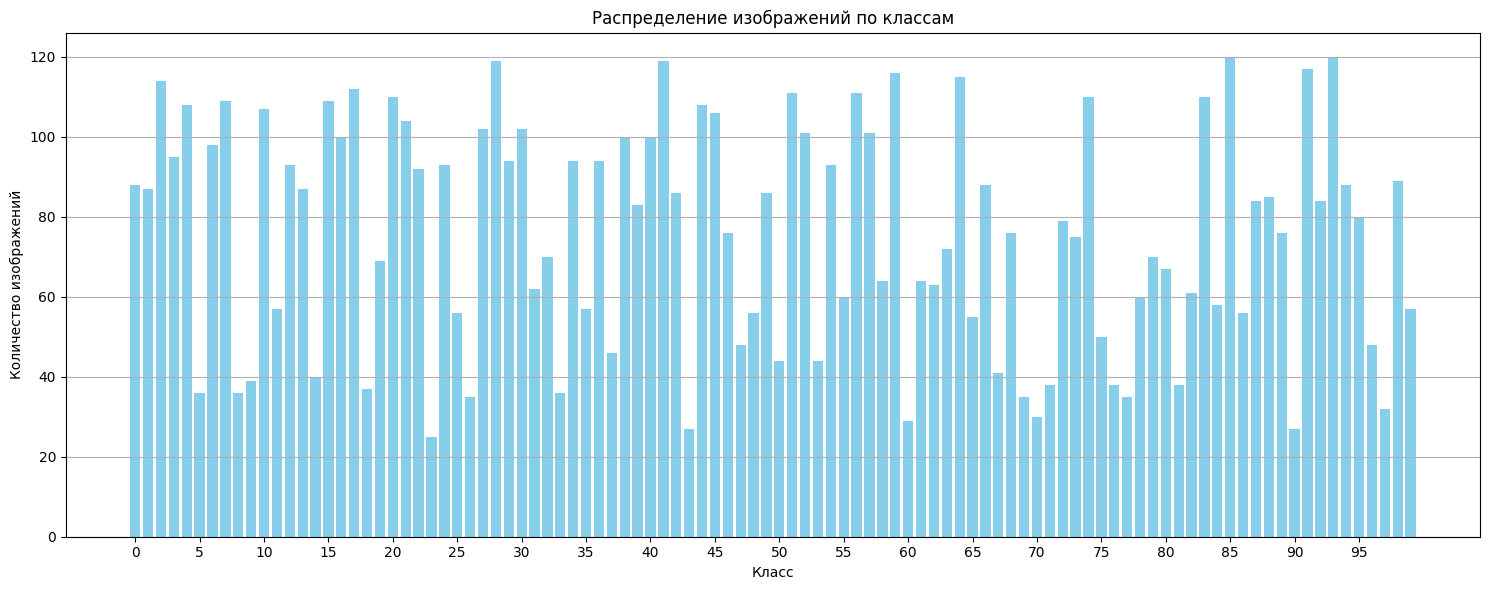

In [ ]:
classes = list(amount_of_classes.keys())
counts = list(amount_of_classes.values())
plt.figure(figsize=(15, 6))
plt.bar(classes, counts, color="skyblue")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(ticks=range(0, max(classes) + 1, max(1, len(classes) // 20)))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Заметен дисбаланс! посмотрим, какие классы представлены реже всего, будем решать эту проблему с помощью семплера и условной аугментации (добавлена в функцию датасета)

Выведем самые редкие классы:

In [ ]:
rare_class = sorted(amount_of_classes.items(), key=lambda x: x[1])[:15]
for class_id, count in rare_class:
    print(f"Класс {class_id}: {count} изображений")

Класс 23: 25 изображений
Класс 43: 27 изображений
Класс 90: 27 изображений
Класс 60: 29 изображений
Класс 70: 30 изображений
Класс 97: 32 изображений
Класс 26: 35 изображений
Класс 69: 35 изображений
Класс 77: 35 изображений
Класс 33: 36 изображений
Класс 5: 36 изображений
Класс 8: 36 изображений
Класс 18: 37 изображений
Класс 71: 38 изображений
Класс 76: 38 изображений


Поставлю порог для условной аугментации на 40 картинок

In [ ]:
# посмотрим, какого размера картинки
H, W, C = cv2.imread("./data/train/0/5926.png").shape
print(f"Размер изображения: {W}x{H}, каналов: {C}")

Размер изображения: 32x32, каналов: 3


In [ ]:
num_classes = 100

# Необходимые функции

По итогам всего ниже- и вышеперечисленного в каждой модельке будет (если я это не буду специально убирать) (а я не убирала):


*   апскейлинг до 224х224
*   аугментации (навороченные проверю на базовой модели)
*   условная аугментация для очень маленьких классов (там, где картинок <40)
*   график с лосями и метрикой
*   сохранение лучшей модели во время обучения
*   ранняя остановка во время обучения
*   сэмплер для избавления от дисбаланса

по возможности я старалась прикреплять скрины со скором из каггла






In [ ]:
def train_model(model,train_loader,val_loader,criterion,optimizer,device,num_epochs=20,patience=5,save_path="best_model.pth"):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None
    no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}"
        )

        #валидация
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_running_loss += loss.item() * images.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # сохранение модельки
        if val_acc > best_val_acc:
            print(f"Метрика на валидации улучшилась с {best_val_acc:.4f} до {val_acc:.4f}. Сохранение...\n"+ "-" * 60)
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save({
                    "epoch": epoch,
                    "model_state_dict": best_model_state,
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": val_loss,
                    "accuracy": val_acc,
                },
                save_path,
            )
            no_improve = 0
        else:
            no_improve += 1
            print(f"Метрика не улучшается на протяжении {no_improve} эпох. Максимум на данный момент: {best_val_acc:.4f}\n"+ "-" * 60)
        if no_improve >= patience:
            print(f"Сработала ранняя остановка спустя {patience} эпох - нет улучшения в метрике.")
            break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Обучение окончено. Лучшая accuracy на валидации: {best_val_acc:.4f}")

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 5))
    # лоси
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    # аккюраси
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_on_test(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
# посмотреть на предикты на тесте
def show_test_predictions_grid(model, test_loader, device, num_batches=10):
    model.eval()
    batch_shown = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            batch_size = images.size(0)
            plt.figure(figsize=(15, 4))
            for i in range(batch_size):
                img = denormalize(images[i])
                plt.subplot(1, batch_size, i + 1)
                plt.imshow(img)
                plt.title(f"Pred: {preds[i].item()}")
                plt.axis("off")
            plt.tight_layout()
            plt.show()

            batch_shown += 1
            if batch_shown >= num_batches:
                break

------

## Построим базовую модель

построим базовую модель, проверим:

1) обычные аугментации

2) навороченные аугментации

3) попробуем применить аугментации к тесту


In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 12544=256*7*7
        self.out = nn.Linear(12544, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

### сначала обучим модель на обычных аугментациях, потом на навороченных

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    patience=5,
    save_path='best_model_1.pth')

Epoch 1/10 | Train Loss: 4.3864 | Train Acc: 0.0347
Epoch 1/10 | Val Loss: 4.1826 | Val Acc: 0.0733
Метрика на валидации улучшилась с 0.0000 до 0.0733. Сохранение...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.9538 | Train Acc: 0.1012
Epoch 2/10 | Val Loss: 3.7774 | Val Acc: 0.1202
Метрика на валидации улучшилась с 0.0733 до 0.1202. Сохранение...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 3.6071 | Train Acc: 0.1552
Epoch 3/10 | Val Loss: 3.5881 | Val Acc: 0.1563
Метрика на валидации улучшилась с 0.1202 до 0.1563. Сохранение...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 3.3070 | Train Acc: 0.2216
Epoch 4/10 | Val Loss: 3.5447 | Val Acc: 0.1889
Метрика на валидации улучшилась с 0.1563 до 0.1889. Сохранение...
------------------------------------------------------------
Epoch 5/10 | Train Loss: 3.1378 | Train Acc: 0.2554
Epoch 5/10 | Val Loss: 3.4888 | Val Acc:

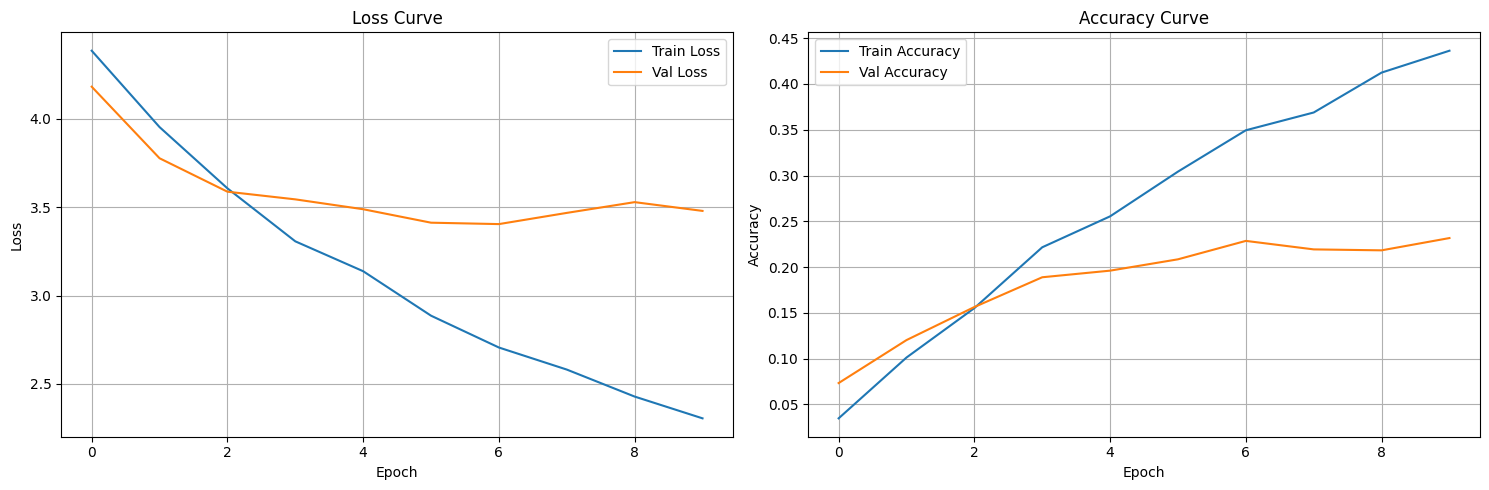

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

### Теперь посмотрим на метрику с навороченными аугментациями

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform_navorochenny, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

тут уже проверю на 7 эпохах, в целом, движение скора будет понятно:

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_navorot.pth')

Epoch 1/7 | Train Loss: 4.3737 | Train Acc: 0.0367
Epoch 1/7 | Val Loss: 4.1814 | Val Acc: 0.0604
Метрика на валидации улучшилась с 0.0000 до 0.0604. Сохранение...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 4.0570 | Train Acc: 0.0777
Epoch 2/7 | Val Loss: 3.9460 | Val Acc: 0.0960
Метрика на валидации улучшилась с 0.0604 до 0.0960. Сохранение...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.8734 | Train Acc: 0.1146
Epoch 3/7 | Val Loss: 3.7417 | Val Acc: 0.1254
Метрика на валидации улучшилась с 0.0960 до 0.1254. Сохранение...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.6699 | Train Acc: 0.1359
Epoch 4/7 | Val Loss: 3.7939 | Val Acc: 0.1238
Метрика не улучшается на протяжении 1 эпох. Максимум на данный момент: 0.1254
------------------------------------------------------------
Epoch 5/7 | Train Loss: 3.5019 | Train Acc: 0.1688
Epoch 5/7 | Val Loss: 3.6680 | Val Ac

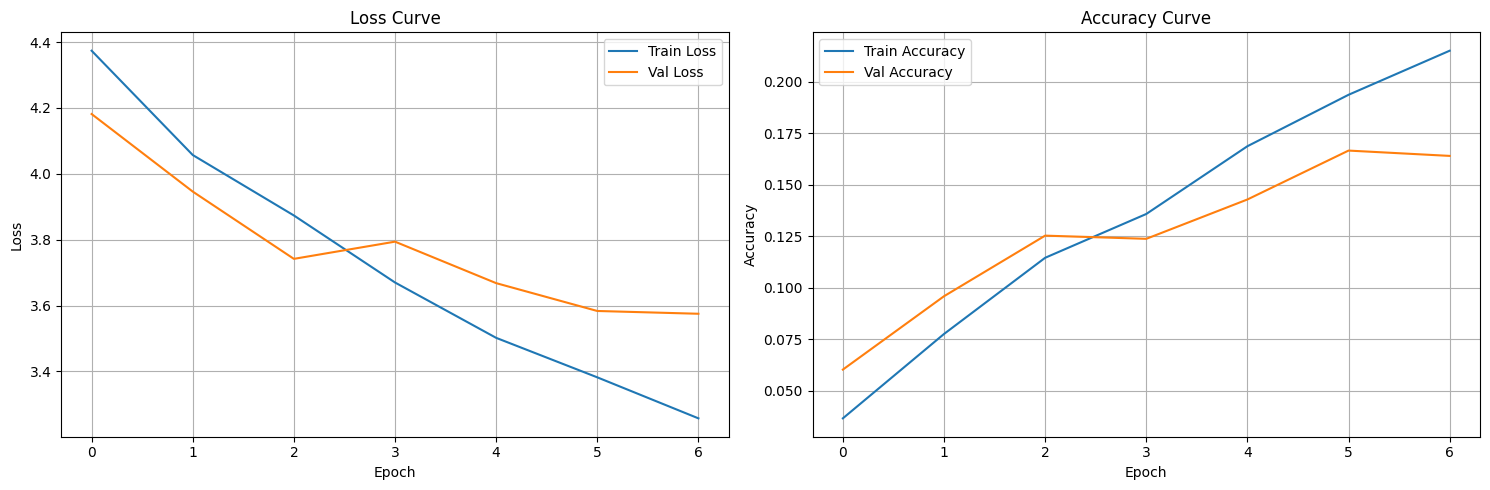

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

можно заметить, что дело пошло хуже, чем было до этого, оставим обычные агументации

### но что, если применять агументацию на тесте? 😧

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=train_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_ofiget.pth')

Epoch 1/7 | Train Loss: 4.3231 | Train Acc: 0.0399
Epoch 1/7 | Val Loss: 4.1646 | Val Acc: 0.0619
Метрика на валидации улучшилась с 0.0000 до 0.0619. Сохранение...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 3.9773 | Train Acc: 0.0894
Epoch 2/7 | Val Loss: 3.9179 | Val Acc: 0.1022
Метрика на валидации улучшилась с 0.0619 до 0.1022. Сохранение...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.6493 | Train Acc: 0.1553
Epoch 3/7 | Val Loss: 3.7343 | Val Acc: 0.1419
Метрика на валидации улучшилась с 0.1022 до 0.1419. Сохранение...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.3352 | Train Acc: 0.2180
Epoch 4/7 | Val Loss: 3.5883 | Val Acc: 0.1739
Метрика на валидации улучшилась с 0.1419 до 0.1739. Сохранение...
------------------------------------------------------------
Epoch 5/7 | Train Loss: 3.0892 | Train Acc: 0.2656
Epoch 5/7 | Val Loss: 3.4597 | Val Acc: 0.1914
Ме

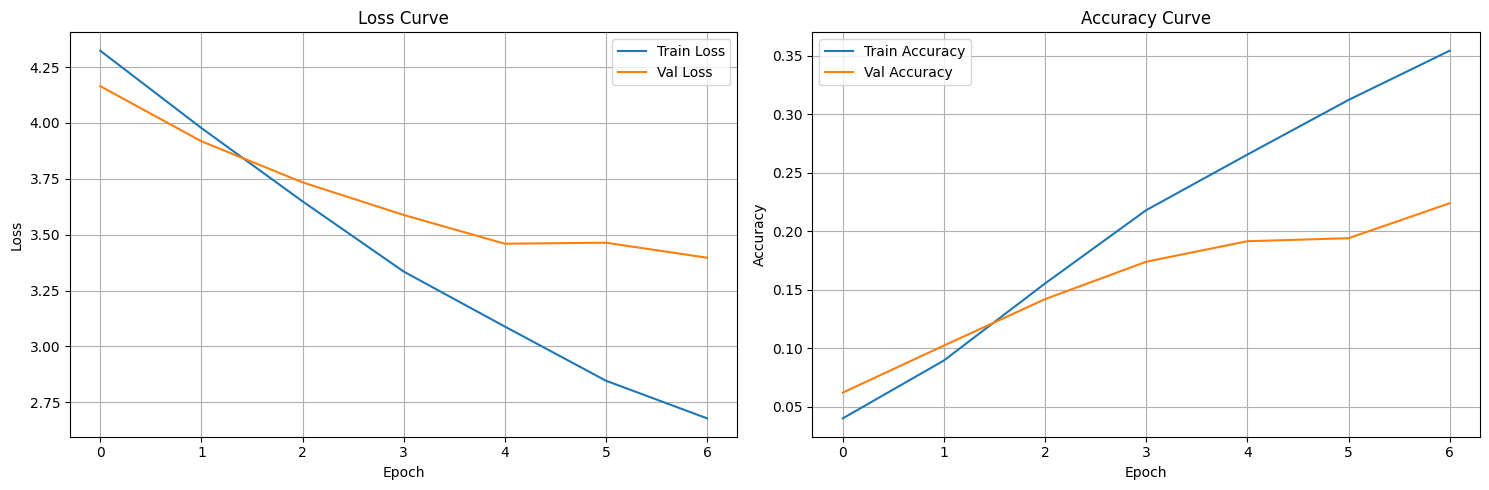

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

и все равно хуже, чем базовые аугментации. оставим их

------

## Resnet50

возьмем предобученную модель (далее берутся также предобученные модели)

In [ ]:
model_3 = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [ ]:
for param in model_3.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 100)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_3.parameters(), lr=0.001)

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train",split="train",transform=train_transform,rare_class_transform=rare_class_transform,)
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_3, train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = train_model(model_3,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_resnet50.pth")

Epoch 1/10 | Train Loss: 3.8971 | Train Acc: 0.1544
Epoch 1/10 | Val Loss: 2.7422 | Val Acc: 0.3911
Метрика на валидации улучшилась с 0.0000 до 0.3911. Сохранение...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 2.8717 | Train Acc: 0.3242
Epoch 2/10 | Val Loss: 2.2142 | Val Acc: 0.4530
Метрика на валидации улучшилась с 0.3911 до 0.4530. Сохранение...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.5045 | Train Acc: 0.3896
Epoch 3/10 | Val Loss: 1.9473 | Val Acc: 0.5093
Метрика на валидации улучшилась с 0.4530 до 0.5093. Сохранение...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.3528 | Train Acc: 0.4134
Epoch 4/10 | Val Loss: 1.8925 | Val Acc: 0.5119
Метрика на валидации улучшилась с 0.5093 до 0.5119. Сохранение...
------------------------------------------------------------
Epoch 5/10 | Train Loss: 2.2345 | Train Acc: 0.4324
Epoch 5/10 | Val Loss: 1.7422 | Val Acc:

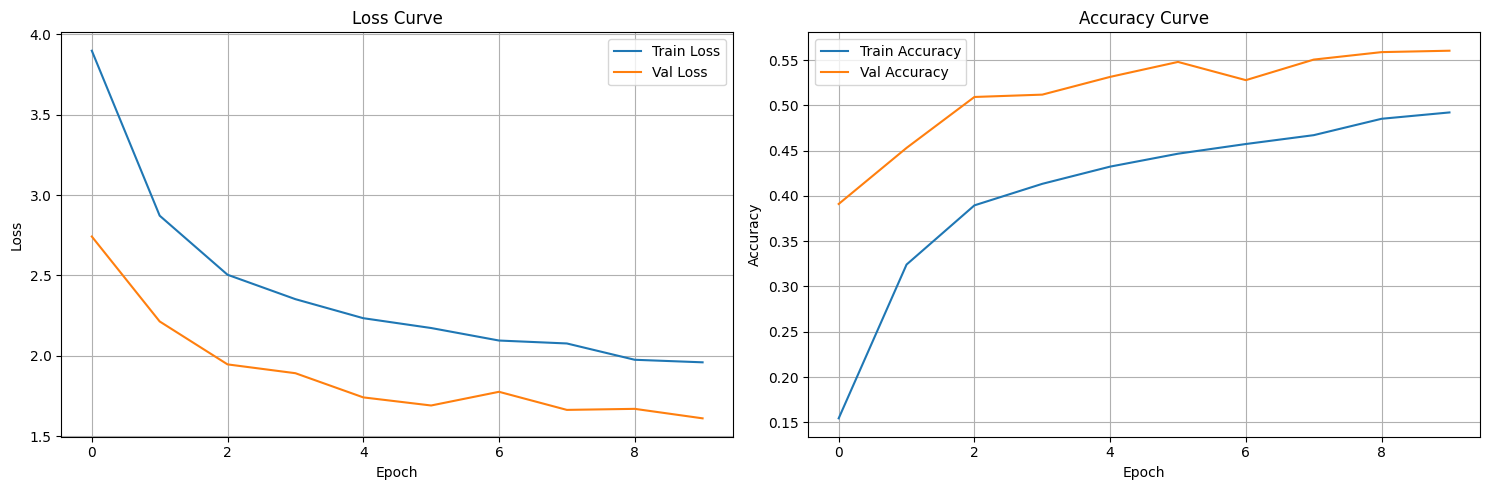

In [ ]:
plot_training_curves(train_losses_3,  val_losses_3,train_accuracies_3, val_accuracies_3)

### пофайнтюним

In [ ]:
for param in model_3.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_3.parameters(), lr=0.0001)

In [ ]:
model_3, train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 =train_model(model_3,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="best_model_resnet50_fine.pth")

Epoch 1/20 | Train Loss: 1.3136 | Train Acc: 0.6348
Epoch 1/20 | Val Loss: 1.1582 | Val Acc: 0.6589
Метрика на валидации улучшилась с 0.0000 до 0.6589. Сохранение...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.8289 | Train Acc: 0.7619
Epoch 2/20 | Val Loss: 0.9797 | Val Acc: 0.7116
Метрика на валидации улучшилась с 0.6589 до 0.7116. Сохранение...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.6090 | Train Acc: 0.8261
Epoch 3/20 | Val Loss: 0.9608 | Val Acc: 0.7317
Метрика на валидации улучшилась с 0.7116 до 0.7317. Сохранение...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.4748 | Train Acc: 0.8670
Epoch 4/20 | Val Loss: 1.0033 | Val Acc: 0.7136
Метрика не улучшается на протяжении 1 эпох. Максимум на данный момент: 0.7317
------------------------------------------------------------
Epoch 5/20 | Train Loss: 0.3628 | Train Acc: 0.9002
Epoch 5/20 | Val Loss: 0.950

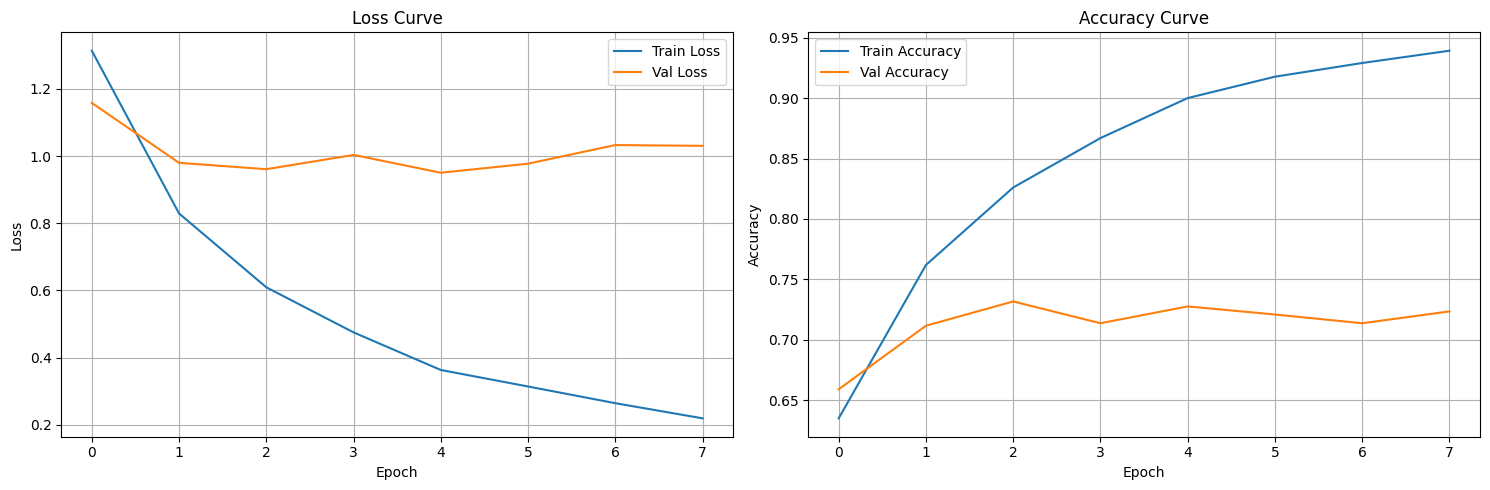

In [ ]:
plot_training_curves(train_losses_3,  val_losses_3,train_accuracies_3, val_accuracies_3)

предскажем

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
my_submit['target']=predict_on_test(model_3, test_loader, device)

In [ ]:
my_submit.to_csv('resnet50_popitka.csv', index=False)

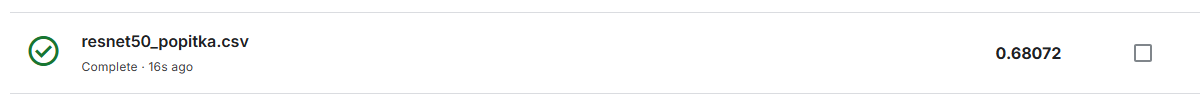

------

## **EfficientNetb3 ( ЛУЧШАЯ НА КАГГЛЕ МОДЕЛЬ - 0.78 )**

кратко и по делу: берем предобученную модель, замораживаем слои, обучаем, размораживаем слои, файнтюним.

по структуре:


*   трансформер с базовыми аугментациями (поворот горизонтально\вертикально, усиление резкости, и немного пропавшие пиксели)
*   условная агументация для редких классов (менее 40 экземпляров)
*   вроде как эта модель хорошо работает на 224х224 - у меня настроен апскейл до этих размеров
*   сначала 15 эпох, потом еще 30 эпох
*   условие для ранней остановки - сначала 5 эпох, потом 10
*   сохранение лучшей модели





In [ ]:
model_5 = models.efficientnet_b3(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 180MB/s]


In [ ]:
for param in model_5.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")

In [ ]:
num_f = model_5.classifier[1].in_features
model_5.classifier[1] = nn.Linear(num_f, 100)
model_5 = model_5.to(device)

In [ ]:
model_5 = model_5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_5.parameters(), lr=0.001)

In [ ]:
model_5, train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 = train_model(model_5,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_efficientnet_b3.pth")

Epoch 1/15 | Train Loss: 4.0149 | Train Acc: 0.1993
Epoch 1/15 | Val Loss: 3.3502 | Val Acc: 0.4303
Метрика на валидации улучшилась с 0.0000 до 0.4303. Сохранение...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 3.1413 | Train Acc: 0.3733
Epoch 2/15 | Val Loss: 2.6703 | Val Acc: 0.4964
Метрика на валидации улучшилась с 0.4303 до 0.4964. Сохранение...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 2.6819 | Train Acc: 0.4222
Epoch 3/15 | Val Loss: 2.2825 | Val Acc: 0.5330
Метрика на валидации улучшилась с 0.4964 до 0.5330. Сохранение...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 2.4661 | Train Acc: 0.4452
Epoch 4/15 | Val Loss: 2.0661 | Val Acc: 0.5475
Метрика на валидации улучшилась с 0.5330 до 0.5475. Сохранение...
------------------------------------------------------------
Epoch 5/15 | Train Loss: 2.2884 | Train Acc: 0.4626
Epoch 5/15 | Val Loss: 1.9220 | Val Acc:

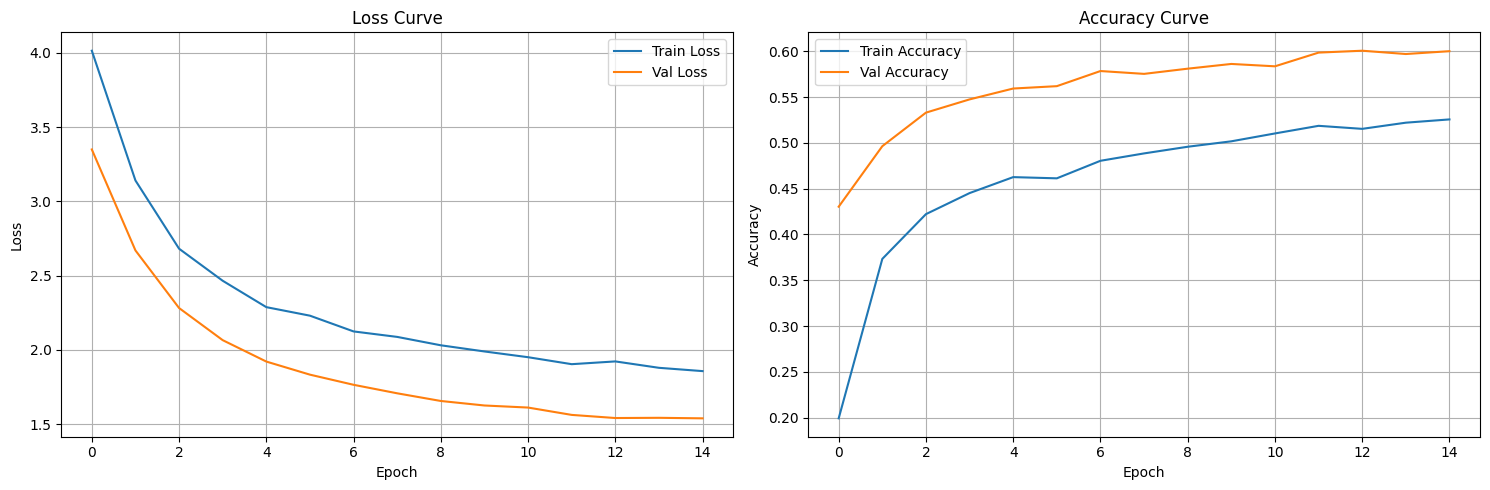

In [ ]:
plot_training_curves(train_losses_5, val_losses_5, train_accuracies_5, val_accuracies_5)

запредиктим:

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
my_submit['target']=predict_on_test(model_5, test_loader, device)

In [ ]:
my_submit.to_csv('efficientnet_b3.csv', index=False)

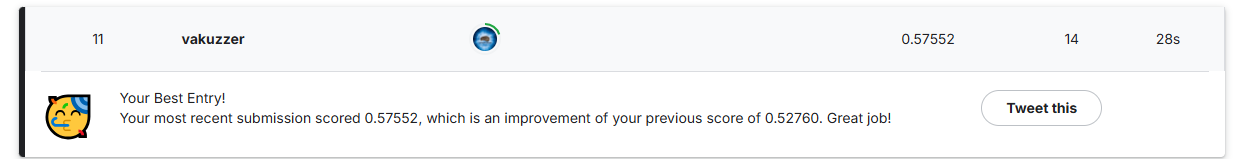

### пофайтюним

In [ ]:
for param in model_5.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_5.parameters(), lr=0.0001)

In [ ]:
model_5, train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 =train_model(model_5,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=30,
    patience=10,
    save_path="best_model_efficientnet_b3_fine.pth")

Epoch 1/30 | Train Loss: 1.3914 | Train Acc: 0.6198
Epoch 1/30 | Val Loss: 1.0044 | Val Acc: 0.7208
Метрика на валидации улучшилась с 0.0000 до 0.7208. Сохранение...
------------------------------------------------------------
Epoch 2/30 | Train Loss: 0.9831 | Train Acc: 0.7239
Epoch 2/30 | Val Loss: 0.8766 | Val Acc: 0.7456
Метрика на валидации улучшилась с 0.7208 до 0.7456. Сохранение...
------------------------------------------------------------
Epoch 3/30 | Train Loss: 0.8146 | Train Acc: 0.7598
Epoch 3/30 | Val Loss: 0.8045 | Val Acc: 0.7637
Метрика на валидации улучшилась с 0.7456 до 0.7637. Сохранение...
------------------------------------------------------------
Epoch 4/30 | Train Loss: 0.6783 | Train Acc: 0.7999
Epoch 4/30 | Val Loss: 0.7630 | Val Acc: 0.7781
Метрика на валидации улучшилась с 0.7637 до 0.7781. Сохранение...
------------------------------------------------------------
Epoch 5/30 | Train Loss: 0.5581 | Train Acc: 0.8393
Epoch 5/30 | Val Loss: 0.7456 | Val Acc:

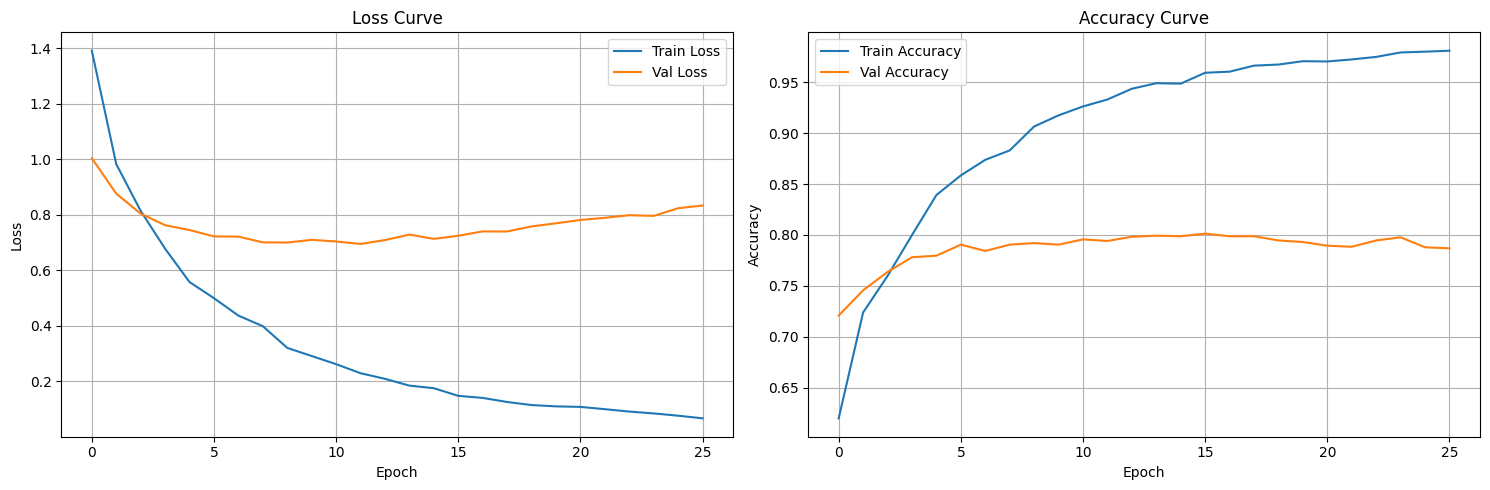

In [ ]:
plot_training_curves(train_losses_5,  val_losses_5,train_accuracies_5, val_accuracies_5)

## ОТВЕТ ЛУЧШЕЙ МОДЕЛИ В КАГГЛЕ

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_5, test_loader, device)
my_submit.to_csv('efficientnet_b3_fine_2.csv', index=False)

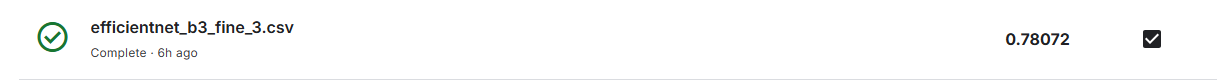

-----

## efficientnet_b5

In [ ]:
model_net = models.efficientnet_b5(weights="IMAGENET1K_V1")

In [ ]:
for param in model_net.parameters():
    param.requires_grad = False

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
num_ftrs = model_net.classifier[1].in_features
model_net.classifier[1] = nn.Linear(num_ftrs, 100)
model_net = model_net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_net, train_losses_net, train_accuracies_net, val_losses_net, val_accuracies_net = train_model(model_net,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_efficientnet_b5.pth")

Epoch 1/15 | Train Loss: 3.8917 | Train Acc: 0.2229
Epoch 1/15 | Val Loss: 3.2627 | Val Acc: 0.3612
Метрика на валидации улучшилась с 0.0000 до 0.3612. Сохранение...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 3.0081 | Train Acc: 0.3535
Epoch 2/15 | Val Loss: 2.7776 | Val Acc: 0.4236
Метрика на валидации улучшилась с 0.3612 до 0.4236. Сохранение...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 2.6516 | Train Acc: 0.3953
Epoch 3/15 | Val Loss: 2.5210 | Val Acc: 0.4463
Метрика на валидации улучшилась с 0.4236 до 0.4463. Сохранение...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 2.4483 | Train Acc: 0.4262
Epoch 4/15 | Val Loss: 2.3707 | Val Acc: 0.4623
Метрика на валидации улучшилась с 0.4463 до 0.4623. Сохранение...
------------------------------------------------------------
Epoch 5/15 | Train Loss: 2.3110 | Train Acc: 0.4496
Epoch 5/15 | Val Loss: 2.2565 | Val Acc:

### пофайнтюним

In [ ]:
for param in model_net.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_net.parameters(), lr=0.0001)

In [ ]:
model_net, train_losses_net, train_accuracies_net, val_losses_net, val_accuracies_net =train_model(model_net,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="best_model_efficientnet_b5_fine.pth")

Epoch 1/20 | Train Loss: 1.3473 | Train Acc: 0.6342
Epoch 1/20 | Val Loss: 1.1269 | Val Acc: 0.6863
Метрика на валидации улучшилась с 0.0000 до 0.6863. Сохранение...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.8392 | Train Acc: 0.7606
Epoch 2/20 | Val Loss: 0.9841 | Val Acc: 0.7224
Метрика на валидации улучшилась с 0.6863 до 0.7224. Сохранение...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.6428 | Train Acc: 0.8184
Epoch 3/20 | Val Loss: 0.9284 | Val Acc: 0.7384
Метрика на валидации улучшилась с 0.7224 до 0.7384. Сохранение...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.5031 | Train Acc: 0.8613
Epoch 4/20 | Val Loss: 0.8859 | Val Acc: 0.7446
Метрика на валидации улучшилась с 0.7384 до 0.7446. Сохранение...
------------------------------------------------------------
Epoch 5/20 | Train Loss: 0.3864 | Train Acc: 0.8912
Epoch 5/20 | Val Loss: 0.8543 | Val Acc:

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_net, test_loader, device)
my_submit.to_csv('efficientnet_b5_fine.csv', index=False)

## mobilenet_v3_small

In [ ]:
model_mobilenet = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_mobilenet.parameters():
    param.requires_grad = False

In [ ]:
model_mobilenet.classifier[-1] = nn.Linear(1024, 100)
model_mobilenet = model_mobilenet.to(device)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mobilenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_mobilenet, train_losses_6, train_accuracies_6, val_losses_6, val_accuracies_6 = train_model(model_mobilenet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_mobilenet.pth")

Epoch 1/10 | Train Loss: 3.6907 | Train Acc: 0.2340
Epoch 1/10 | Val Loss: 2.6655 | Val Acc: 0.4272
Метрика на валидации улучшилась с 0.0000 до 0.4272. Сохранение...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 2.6794 | Train Acc: 0.4056
Epoch 2/10 | Val Loss: 2.0493 | Val Acc: 0.5036
Метрика на валидации улучшилась с 0.4272 до 0.5036. Сохранение...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.3334 | Train Acc: 0.4546
Epoch 3/10 | Val Loss: 1.8605 | Val Acc: 0.5253
Метрика на валидации улучшилась с 0.5036 до 0.5253. Сохранение...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.1355 | Train Acc: 0.4831
Epoch 4/10 | Val Loss: 1.7622 | Val Acc: 0.5439
Метрика на валидации улучшилась с 0.5253 до 0.5439. Сохранение...
------------------------------------------------------------
Epoch 5/10 | Train Loss: 2.0079 | Train Acc: 0.5028
Epoch 5/10 | Val Loss: 1.6936 | Val Acc:

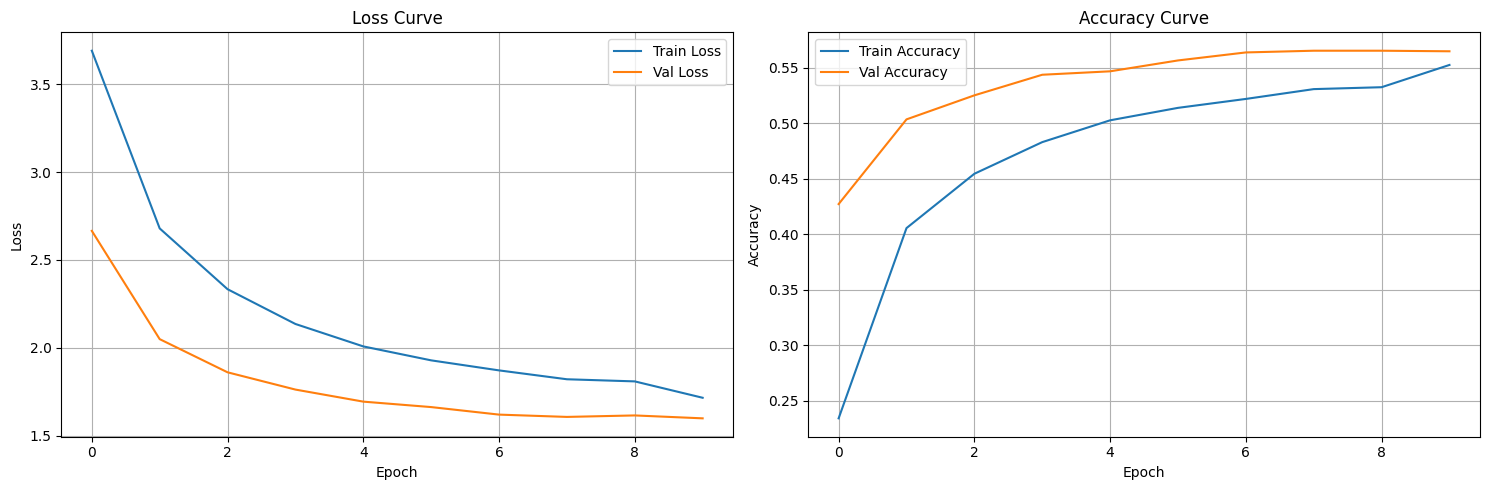

In [ ]:
plot_training_curves(train_losses_6,  val_losses_6,train_accuracies_6, val_accuracies_6)

### пофайнтюним

In [ ]:
for param in model_mobilenet.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_mobilenet.parameters(), lr=0.0001)

In [ ]:
model_mobilenet, train_losses_6, train_accuracies_6, val_losses_6, val_accuracies_6 =train_model(model_mobilenet,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_mobilenet_fine.pth")

Epoch 1/15 | Train Loss: 1.3037 | Train Acc: 0.6368
Epoch 1/15 | Val Loss: 2.3407 | Val Acc: 0.4613
Метрика на валидации улучшилась с 0.0000 до 0.4613. Сохранение...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 0.9489 | Train Acc: 0.7240
Epoch 2/15 | Val Loss: 1.7801 | Val Acc: 0.5495
Метрика на валидации улучшилась с 0.4613 до 0.5495. Сохранение...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 0.7767 | Train Acc: 0.7775
Epoch 3/15 | Val Loss: 1.6577 | Val Acc: 0.5789
Метрика на валидации улучшилась с 0.5495 до 0.5789. Сохранение...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 0.6425 | Train Acc: 0.8133
Epoch 4/15 | Val Loss: 1.4908 | Val Acc: 0.6017
Метрика на валидации улучшилась с 0.5789 до 0.6017. Сохранение...
------------------------------------------------------------
Epoch 5/15 | Train Loss: 0.5253 | Train Acc: 0.8413
Epoch 5/15 | Val Loss: 1.5376 | Val Acc:

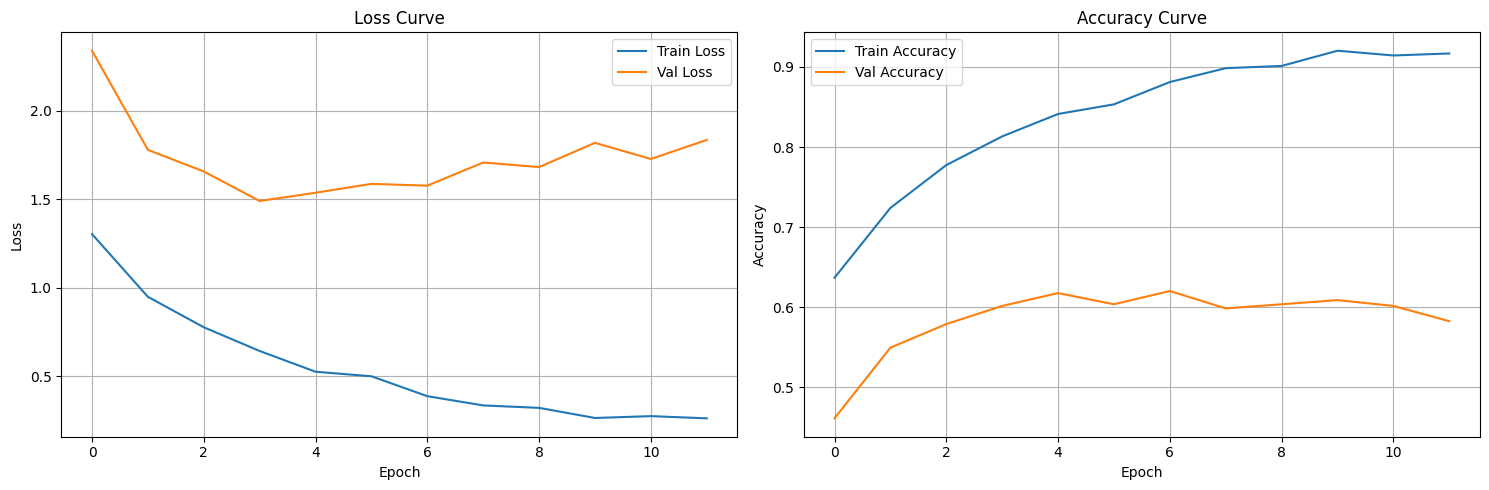

In [ ]:
plot_training_curves(train_losses_6,  val_losses_6,train_accuracies_6, val_accuracies_6)

запредиктим

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_mobilenet, test_loader, device)
my_submit.to_csv('model_mobilenet_fine_2.csv', index=False)

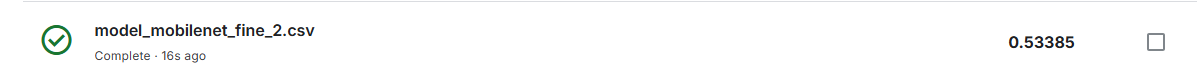

------

## densenet-169

In [ ]:
model_densenet = models.densenet169(pretrained=True)

for param in model_densenet.parameters():
    param.requires_grad = False

num_features = model_densenet.classifier.in_features
model_densenet.fc=nn.Linear(num_features, 100)

for param in model_densenet.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 201MB/s]


In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_densenet = model_densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_densenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_densenet, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet = train_model(model_densenet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_densenet169.pth")

Epoch 1/10 | Train Loss: 5.4485 | Train Acc: 0.0449
Epoch 1/10 | Val Loss: 4.2754 | Val Acc: 0.1089
Метрика на валидации улучшилась с 0.0000 до 0.1089. Сохранение...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.6435 | Train Acc: 0.1734
Epoch 2/10 | Val Loss: 3.0437 | Val Acc: 0.2714
Метрика на валидации улучшилась с 0.1089 до 0.2714. Сохранение...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.9484 | Train Acc: 0.2866
Epoch 3/10 | Val Loss: 2.4702 | Val Acc: 0.3875
Метрика на валидации улучшилась с 0.2714 до 0.3875. Сохранение...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.5333 | Train Acc: 0.3677
Epoch 4/10 | Val Loss: 2.1317 | Val Acc: 0.4659
Метрика на валидации улучшилась с 0.3875 до 0.4659. Сохранение...
------------------------------------------------------------
Epoch 5/10 | Train Loss: 2.2687 | Train Acc: 0.4304
Epoch 5/10 | Val Loss: 1.9427 | Val Acc:

### пофайтюним

In [ ]:
for param in model_densenet.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_densenet.parameters(), lr=0.0001)

In [ ]:
model_densenet, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet =train_model(model_densenet,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="model_densenet_fine.pth")

Epoch 1/20 | Train Loss: 0.8190 | Train Acc: 0.7670
Epoch 1/20 | Val Loss: 0.9655 | Val Acc: 0.7100
Метрика на валидации улучшилась с 0.0000 до 0.7100. Сохранение...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.5866 | Train Acc: 0.8332
Epoch 2/20 | Val Loss: 0.9068 | Val Acc: 0.7214
Метрика на валидации улучшилась с 0.7100 до 0.7214. Сохранение...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.4177 | Train Acc: 0.8883
Epoch 3/20 | Val Loss: 0.8956 | Val Acc: 0.7384
Метрика на валидации улучшилась с 0.7214 до 0.7384. Сохранение...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.3323 | Train Acc: 0.9120
Epoch 4/20 | Val Loss: 0.8655 | Val Acc: 0.7415
Метрика на валидации улучшилась с 0.7384 до 0.7415. Сохранение...
------------------------------------------------------------
Epoch 5/20 | Train Loss: 0.2511 | Train Acc: 0.9337
Epoch 5/20 | Val Loss: 0.8600 | Val Acc:

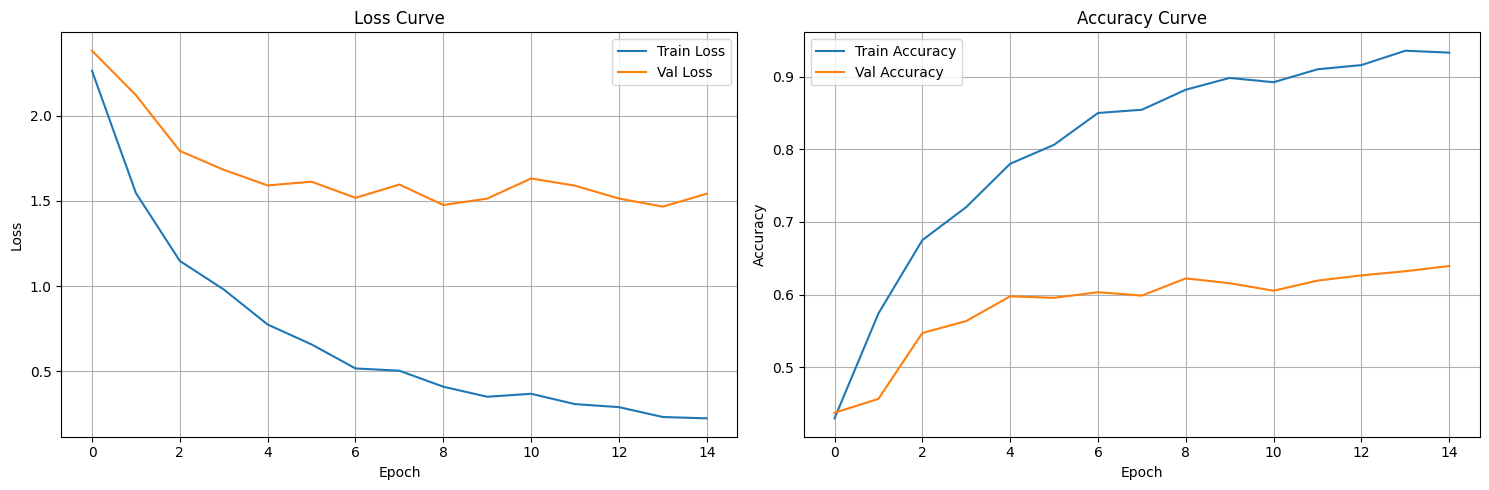

In [ ]:
plot_training_curves(train_losses_densenet,  val_losses_densenet,train_accuracies_densenet, val_accuracies_densenet)

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_densenet, test_loader, device)
my_submit.to_csv('model_densenet_fine.csv', index=False)

-----

## немного словим шизу - 512х512 - efficientnet_v2_l

In [ ]:
train_transform_shiza = A.Compose(
    [
        A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=0.1),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.Normalize(),
        ToTensorV2(),
    ]
)

rare_class_transform_shiza = A.Compose(
    [
        A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transform_shiza = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform_shiza, rare_class_transform=rare_class_transform_shiza )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform_shiza)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform_shiza)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_7 =models.efficientnet_v2_l(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 76.9MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for param in model_7.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_7.classifier[1].in_features
model_7.classifier[1] = nn.Linear(num_ftrs, 100)
model_7 = model_7.to(device)

In [ ]:
model_7 = model_7.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_7.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_7, train_losses_7, train_accuracies_7, val_losses_7, val_accuracies_7 = train_model(model_7,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_efficientnet_v2_l.pth")

Epoch 1/10 | Train Loss: 4.2165 | Train Acc: 0.0856
Epoch 1/10 | Val Loss: 3.3653 | Val Acc: 0.2802
Метрика на валидации улучшилась с 0.0000 до 0.2802. Сохранение...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.4249 | Train Acc: 0.2241
Epoch 2/10 | Val Loss: 2.7931 | Val Acc: 0.3906
Метрика на валидации улучшилась с 0.2802 до 0.3906. Сохранение...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 3.0618 | Train Acc: 0.2793
Epoch 3/10 | Val Loss: 2.4474 | Val Acc: 0.4319
Метрика на валидации улучшилась с 0.3906 до 0.4319. Сохранение...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.8561 | Train Acc: 0.3127
Epoch 4/10 | Val Loss: 2.2037 | Val Acc: 0.4819
Метрика на валидации улучшилась с 0.4319 до 0.4819. Сохранение...
------------------------------------------------------------
Epoch 5/10 | Train Loss: 2.7381 | Train Acc: 0.3444
Epoch 5/10 | Val Loss: 2.1450 | Val Acc:

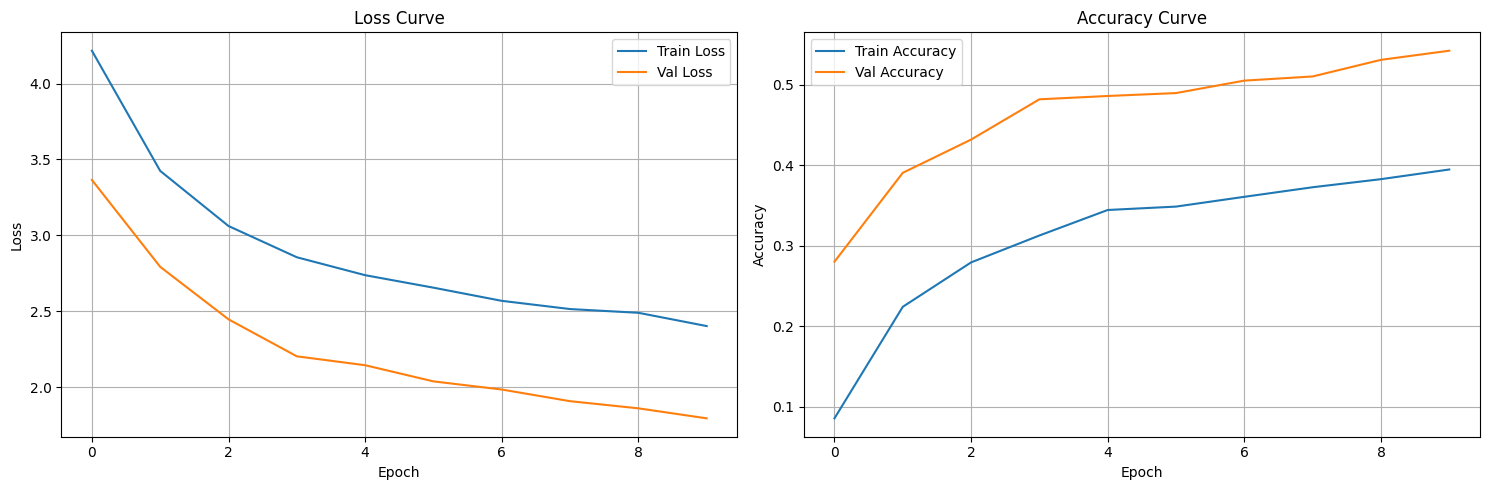

In [ ]:
plot_training_curves(train_losses_7,  val_losses_7, train_accuracies_7, val_accuracies_7)

предикт

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_7, test_loader, device)
my_submit.to_csv('model_efficientnet_v2_l.csv', index=False)

### пофайнтюним

In [ ]:
for param in model_7.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_7.parameters(), lr=0.0001)

In [ ]:
model_7, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet =train_model(model_7,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=10,
    patience=5,
    save_path="model_efficientnet_v2_l_fine.pth")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 248.12 MiB is free. Process 2408 has 14.50 GiB memory in use. Of the allocated memory 13.65 GiB is allocated by PyTorch, and 727.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

шиза не словилась, гпу в коллабе закончился (а начиналось так красиво....)

----------

# построим cGAN

построила ган по типу того, что был на семинаре:

In [ ]:
latent_dim = 100
num_classes = 100
image_size = 224
channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# наш мошенник
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.init_size = image_size // 16
        self.l1 = nn.Linear(latent_dim + num_classes, 512 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()  # от -1 до 1!
        )

    def forward(self, noise, labels):
        # заванхотим метки классов
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        gen_input = torch.cat((noise, label_onehot), dim=-1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# наш борец за справедливость
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            block.extend([nn.ReLU(), nn.Dropout2d(0.25)])
            return block
        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels + num_classes, 64, bn=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        label_map = label_onehot.view(labels.size(0), self.num_classes, 1, 1).expand(-1, -1, img.size(2), img.size(3))
        conditioned_img = torch.cat((img, label_map), dim=1)
        out = self.conv_blocks(conditioned_img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# попроубем запустить модельки
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


def train(num_epochs):
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            batch_size = real_imgs.size(0)
            # обозначаем реальные и фейковые фотки
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)
            # обучим наш дискриминатор
            optimizer_D.zero_grad()
            output_real = D(real_imgs, labels)
            loss_real = criterion(output_real, valid)

            # Генерация фейковых изображений
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = G(noise, labels)

            # Потери на фейковых изображениях
            output_fake = D(fake_imgs.detach(), labels)
            loss_fake = criterion(output_fake, fake)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # обучим наш генератор
            optimizer_G.zero_grad()
            output = D(fake_imgs, labels)
            loss_G = criterion(output, valid)
            loss_G.backward()
            optimizer_G.step()
            # и просто чекнем результаты
            if i % 50 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")


train(num_epochs=10)



[Epoch 0/10] [Batch 0/119] [D loss: 0.6914] [G loss: 0.6699]
[Epoch 0/10] [Batch 50/119] [D loss: 0.7604] [G loss: 1.2551]
[Epoch 0/10] [Batch 100/119] [D loss: 0.0809] [G loss: 2.8665]
[Epoch 1/10] [Batch 0/119] [D loss: 0.1597] [G loss: 3.0188]
[Epoch 1/10] [Batch 50/119] [D loss: 0.0258] [G loss: 4.3038]
[Epoch 1/10] [Batch 100/119] [D loss: 0.0882] [G loss: 4.1798]
[Epoch 2/10] [Batch 0/119] [D loss: 0.0047] [G loss: 4.5453]
[Epoch 2/10] [Batch 50/119] [D loss: 0.0016] [G loss: 6.1205]
[Epoch 2/10] [Batch 100/119] [D loss: 0.0020] [G loss: 6.2472]
[Epoch 3/10] [Batch 0/119] [D loss: 0.0020] [G loss: 7.6072]
[Epoch 3/10] [Batch 50/119] [D loss: 0.0004] [G loss: 7.4772]
[Epoch 3/10] [Batch 100/119] [D loss: 0.0018] [G loss: 7.8038]
[Epoch 4/10] [Batch 0/119] [D loss: 0.0046] [G loss: 4.6488]
[Epoch 4/10] [Batch 50/119] [D loss: 0.0485] [G loss: 3.6332]
[Epoch 4/10] [Batch 100/119] [D loss: 0.0089] [G loss: 4.8689]
[Epoch 5/10] [Batch 0/119] [D loss: 0.0050] [G loss: 4.1975]
[Epoch 5/

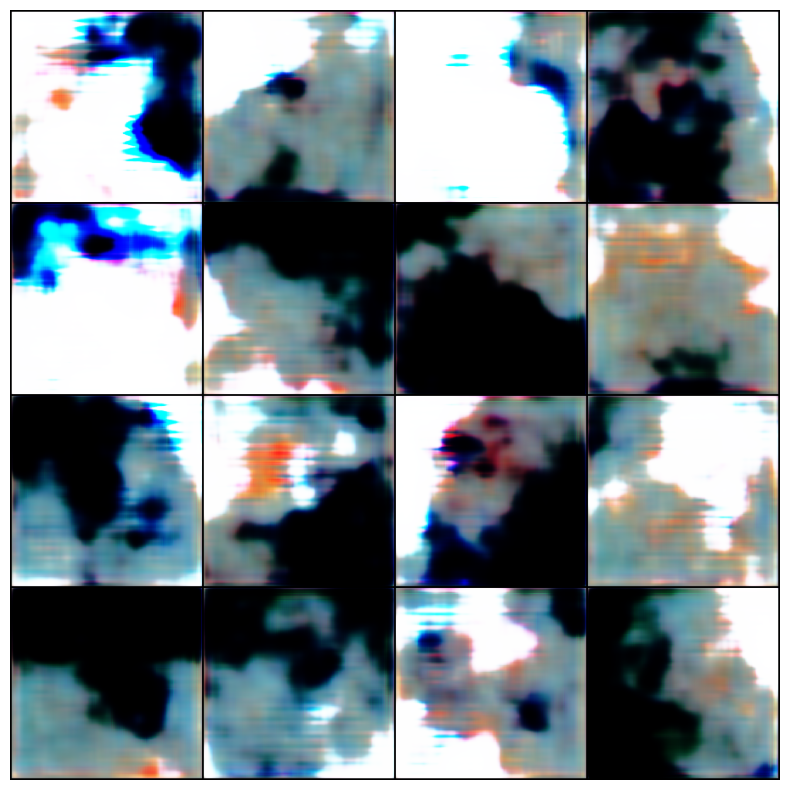

In [ ]:
G.eval()
# посмотрим, как наш мегамозг генерит картинки (выдадим случайно 16 картинок с рандомными метками)
num_images = 16
noise = torch.randn(num_images, latent_dim, device=device)
labels = torch.randint(0, num_classes, (num_images,), device=device)
with torch.no_grad():
    generated_images = G(noise, labels).cpu()
    # не забываем нормализацию
    generated_images = generated_images * 0.5 + 0.5
    grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

отлично! мы нагенерили какую-то жуть. скорее всего, это произошло из-за всего 10 эпох обучения)

In [ ]:
class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        with torch.no_grad():
            noise = torch.randn(num_samples, latent_dim, device=device)
            labels = torch.randint(0, num_classes, (num_samples,), device=device)
            self.images = generator(noise, labels).cpu()
            self.labels = labels.cpu()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
# генерим 100 фоток и создаем смешанный датасет

num_generated = 100
generated_dataset = GeneratedDataset(G, num_generated, latent_dim, num_classes, device)
combo_dataset = ConcatDataset([train_dataset, generated_dataset])


тут у меня закончилась память (при попытке добавить 1000 сгенеренных фоток) ) но не сдаемся, и добавляем хотя бы 100 сгенерированных фоток



In [ ]:
def collate_function(batch):
    images = torch.stack([item[0] for item in batch])
    labels = []
    for item in batch:
      # если метка = тензор, то оставляем, если метка = число, то превращаем ее в тензор
        if isinstance(item[1], torch.Tensor):
            labels.append(item[1])
        else:
          # не забываем коварный .long
            labels.append(torch.tensor(item[1], dtype=torch.long))
    return images, torch.stack(labels)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


подгрузим наш датасет

In [ ]:
combo_loader = DataLoader(
    combo_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_function,
    num_workers=4
)

### пробуем оценить влияние

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=combo_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_gan.pth')

Epoch 1/7 | Train Loss: 4.2762 | Train Acc: 0.0610
Epoch 1/7 | Val Loss: 4.0167 | Val Acc: 0.0888
Метрика на валидации улучшилась с 0.0000 до 0.0888. Сохранение...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 3.8229 | Train Acc: 0.1243
Epoch 2/7 | Val Loss: 3.7947 | Val Acc: 0.1373
Метрика на валидации улучшилась с 0.0888 до 0.1373. Сохранение...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.5294 | Train Acc: 0.1734
Epoch 3/7 | Val Loss: 3.6230 | Val Acc: 0.1667
Метрика на валидации улучшилась с 0.1373 до 0.1667. Сохранение...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.2678 | Train Acc: 0.2245
Epoch 4/7 | Val Loss: 3.4506 | Val Acc: 0.1981
Метрика на валидации улучшилась с 0.1667 до 0.1981. Сохранение...
------------------------------------------------------------
Epoch 5/7 | Train Loss: 3.0337 | Train Acc: 0.2668
Epoch 5/7 | Val Loss: 3.3352 | Val Acc: 0.2049
Ме

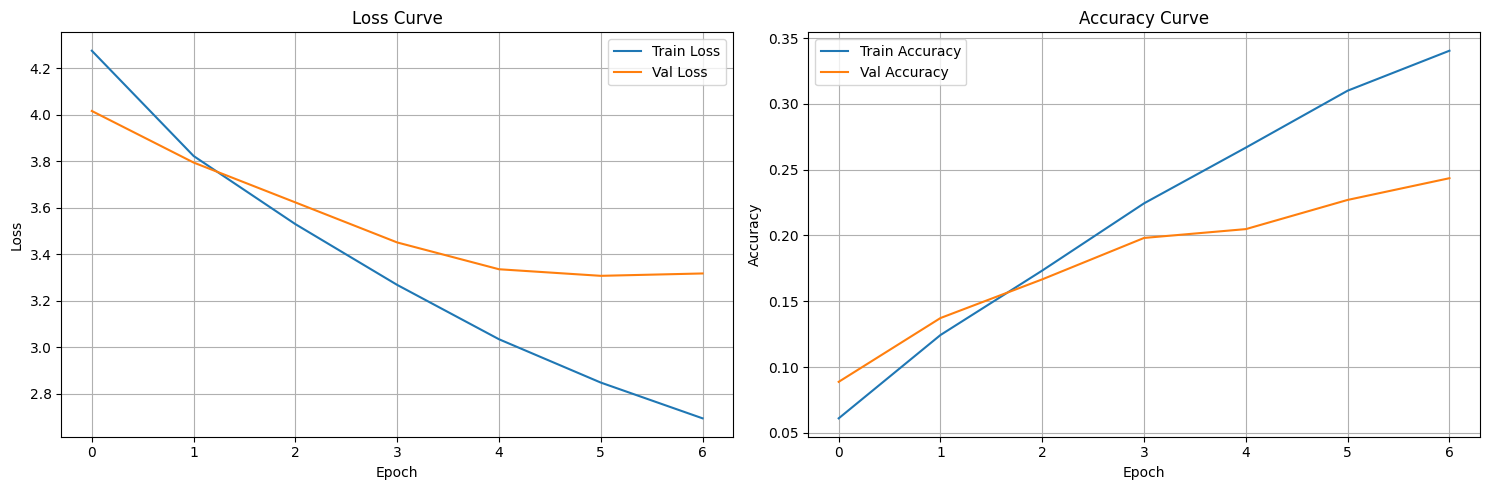

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

работает чуть лучше, чем базовая модель без гана!